In [1]:
from math import ceil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import sigmoid, predict, sigmoid_cross_entropy_with_logits, sigmoid_cross_entropy_with_x_w, sigmoid_cross_entropy_truncated, derivative_cost_wrt_params, backtracking_line_search, check_wolfe_II, check_goldstein, line_search

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve

In [3]:
csv_path = r"C:\Users\Thanh\Downloads\voice_gender\voice.csv"

In [4]:
df = pd.read_csv(csv_path)

In [5]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [6]:
df['label']=df['label'].replace({'male':1,'female':0})

In [7]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,1
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,1
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,1
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,1
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,1


In [8]:
x = df.drop("label", axis=1).to_numpy(dtype=np.float)
y = df["label"].values.astype(np.float)

In [9]:
x = (x - np.min(x, axis=0, keepdims=True))/(np.max(x, axis=0, keepdims=True) - np.min(x, axis=0, keepdims=True))
#x = (x-np.mean(x, axis=0, keepdims=True))/np.std(x, axis=0, keepdims=True)

In [10]:
x

array([[9.64185977e-02, 4.73408557e-01, 8.41252523e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.25828039e-01, 5.05074648e-01, 1.16899775e-01, ...,
        2.14438885e-03, 2.14592275e-03, 5.64489929e-02],
       [1.79222164e-01, 6.75535813e-01, 1.02872692e-01, ...,
        3.57398142e-04, 3.57653791e-04, 4.98851565e-02],
       ...,
       [4.84948580e-01, 7.99042208e-01, 6.90336544e-01, ...,
        1.34024303e-01, 1.34120172e-01, 2.08884632e-01],
       [4.92516043e-01, 7.45692037e-01, 6.95311295e-01, ...,
        1.64045747e-01, 1.64163090e-01, 3.33559435e-01],
       [5.95699639e-01, 7.68963896e-01, 6.87590032e-01, ...,
        2.50178699e-02, 2.50357654e-02, 3.75385802e-01]])

In [11]:
x.shape

(3168, 20)

In [12]:
ones = np.ones(shape=[x.shape[0], 1], dtype=np.float)
x = np.append(x, ones, axis=1)
x.shape

(3168, 21)

In [13]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(x, y)

5

In [14]:
for train_index, val_index in skf.split(x, y):
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

In [15]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((2535, 21), (633, 21), (2535,), (633,))

In [16]:
#weights = np.random.normal(loc=0, scale=np.sqrt(2/(x.shape[1] + 1)), size=x.shape[1])
weights = np.random.normal(loc=0, scale=np.sqrt(2/(x.shape[1])), size=x.shape[1]-1)
weights = np.append(weights, 0.)

In [17]:
weights

array([ 0.01293665, -0.46719843, -0.20538483,  0.04333824,  0.14286046,
       -0.05794175, -0.16844596, -0.11751307,  0.51737108,  0.22588397,
       -0.18869402,  0.13021756, -0.62777608,  0.3777025 ,  0.15409832,
       -0.21539505, -0.19686898,  0.3380577 , -0.03802642, -0.10188177,
        0.        ])

In [18]:
learning_rate = 5

In [19]:
derivative_cost_wrt_params(x=x, w=weights, y=y).shape

(21,)

In [20]:
sigmoid_cross_entropy_with_x_w(x=x, w=weights, y=y)

0.6417365348510001

In [21]:
val_cost_list = {}
val_acc_list = {}

In [22]:
train_cost_list = {}
train_acc_list = {}

In [23]:
wolfe_II_list = {}
goldstein_list = {}

In [24]:
x = x_train
y = y_train
min_val_cost = np.inf
patience = 0
max_weights = weights

val_cost_list["gd"] = []
val_acc_list["gd"] = []

train_cost_list["gd"] = []
train_acc_list["gd"] = []

wolfe_II_list["gd"] = []
goldstein_list["gd"] = []


for i in range(10000):
    dweights = derivative_cost_wrt_params(x=x, w=weights, y=y)
    #print("dweights: {}".format(dweights))
    #dweights = np.linalg.norm(dweights)
    #if i % 1000 == 0:
    #    learning_rate *= 0.9
    #weights -= learning_rate * dweights
    alpha = backtracking_line_search(x=x, w=weights, y=y, p=-dweights, rho=0.9, alpha=10, c=0.0001)
    #alpha = line_search(x=x, w=weights, y=y, p=-dweights, alpha_max=1, c_1=0.0001, c_2=0.0)
    wolfe_II_list["gd"].append(check_wolfe_II(x=x, w=weights, y=y, alpha=alpha, p=-dweights, c_2=0.9))
    goldstein_list["gd"].append(check_goldstein(x=x, w=weights, y=y, alpha=alpha, p=-dweights, c=0.25))
    weights -= alpha * dweights
    #print("Alpha: {}".format(alpha))
    #print(weights)
    cost = sigmoid_cross_entropy_with_x_w(x=x, w=weights, y=y)
    val_cost = sigmoid_cross_entropy_with_x_w(x=x_val, w=weights, y=y_val)
    #output = predict(x=x, w=weights, threshold=0.6).astype(np.float)
    #acc = (output == y).sum()/y.shape[0]
    tr_output = predict(x=x, w=weights, threshold=0.6).astype(np.float)
    tr_acc = (tr_output == y).sum()/y.shape[0]
    val_output = predict(x=x_val, w=weights, threshold=0.6).astype(np.float)
    val_acc = (val_output == y_val).sum()/y_val.shape[0]

    val_cost_list["gd"].append(val_cost)
    val_acc_list["gd"].append(val_acc)

    train_cost_list["gd"].append(cost)
    train_acc_list["gd"].append(tr_acc)

    #print(output == y)
    #print(cost, acc)
    print(cost, val_cost, tr_acc, val_acc, patience)
    if val_cost < min_val_cost:
        min_val_cost = val_cost
        patience = 0
        max_weights = weights
    else:
        patience += 1

    #if patience >= 20 and np.allclose(dweights, np.zeros_like(dweights), rtol=1e-3, atol=1e-5):
    if patience >= 20:
        weights = max_weights
        print("Stop at epoch {}, restore weights".format(i))
        break


tr_output = predict(x=x, w=weights, threshold=0.6).astype(np.float)
tr_acc = (tr_output == y).sum()/y.shape[0]
val_output = predict(x=x_val, w=weights, threshold=0.6).astype(np.float)
val_acc = (val_output == y_val).sum()/y_val.shape[0]
print(cost, val_cost, tr_acc, val_acc)
print(dweights, np.linalg.norm(dweights))

0.6348517218209352 0.6783806969973579 0.5005917159763313 0.5007898894154819 0
0.6055556572382499 0.6451538074112226 0.7928994082840237 0.7330173775671406 0
0.5871518550676941 0.6378040169532417 0.5313609467455621 0.5213270142180095 0
0.5614366777962497 0.6102983230046803 0.8457593688362919 0.8120063191153238 0
0.5440930590991379 0.5994202183112868 0.5877712031558185 0.5402843601895735 0
0.5412685986117405 0.596879088805674 0.8489151873767259 0.8135860979462876 0
0.5409435611792262 0.6019539032302027 0.5952662721893491 0.5418641390205371 0
0.5320252574415006 0.5933107244169488 0.8473372781065088 0.8135860979462876 1
0.5264049301199594 0.5911805331001532 0.609861932938856 0.5481832543443917 0
0.5124728746793279 0.577724096349275 0.8532544378698225 0.8183254344391785 0
0.50279656870208 0.5695806517046805 0.6323471400394477 0.5608214849921012 0
0.4879156132340498 0.5554023427197072 0.867061143984221 0.8309636650868878 0
0.47700827167459503 0.544583469400738 0.6607495069033531 0.56872037914

In [25]:
weights

array([  1.06261329,   1.53520387,  -1.63533003,  -2.53331553,
         3.96879072,   6.77551284,  -1.40519413,  -1.11729168,
         5.29902342,  -4.18827656,   0.55235085,   1.17989419,
       -22.59000701,   2.48631237,  -0.38942383,   0.30974788,
         0.77658698,   0.47448869,   0.07876729,  -0.46548898,
         3.74244745])

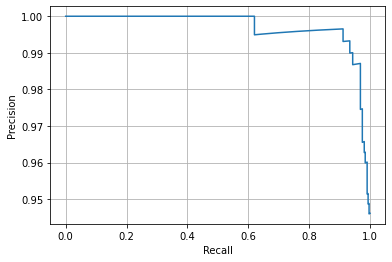

In [26]:
val_prob = predict(x=x_val, w=weights, return_prob=True)
precision, recall, thresholds = precision_recall_curve(y_val, val_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()

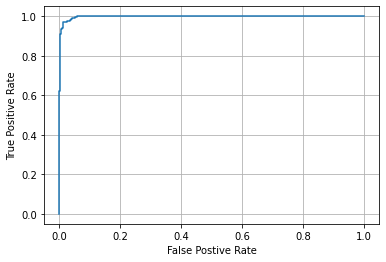

In [27]:
fpr, tpr, thresholds = roc_curve(y_val, val_prob)

plt.plot(fpr, tpr)
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.grid()

In [28]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=100, ).fit(x, y)

val_prob = clf.predict_proba(x_val)
val_predict = np.argmax(val_prob, axis=1)
val_acc = (val_predict == y_val).sum()/y_val.shape[0]

val_acc

0.9684044233807267

In [29]:
num_epochs = 1000
batch_size = 64
weights = np.random.normal(loc=0, scale=np.sqrt(2/(x.shape[1])), size=x.shape[1]-1)
weights = np.append(weights, 0.)
alpha = 1e-1
min_val_cost = np.inf
patience = 0
max_weights = weights

val_cost_list["batch"] = []
val_acc_list["batch"] = []

train_cost_list["batch"] = []
train_acc_list["batch"] = []

wolfe_II_list["batch"] = []
goldstein_list["batch"] = []

for i in range(num_epochs):
    index = np.arange(x_train.shape[0])
    np.random.shuffle(index)
    for j in range(ceil(x_train.shape[0]/64)):
        index_batch = index[j * batch_size: j * batch_size + batch_size]
        x_batch = x_train[index_batch]
        y_batch = y_train[index_batch]
        #x_batch = x_train[j * batch_size: j * batch_size + batch_size]
        #y_batch = y_train[j * batch_size: j * batch_size + batch_size]
        #print(x_batch.shape, y_batch.shape)

        dweights = derivative_cost_wrt_params(x=x_batch, w=weights, y=y_batch)
        alpha = backtracking_line_search(x=x_batch, w=weights, y=y_batch, p=-dweights, rho=0.9, alpha=1e-1, c=0.0001)
        #alpha = line_search(x=x_batch, w=weights, y=y, p=-dweights, alpha_max=1e-1, c_1=0.0001, c_2=0.9)

        wolfe_II_list["batch"].append(check_wolfe_II(x=x_batch, w=weights, y=y_batch, alpha=alpha, p=-dweights, c_2=0.9))
        goldstein_list["batch"].append(check_goldstein(x=x_batch, w=weights, y=y_batch, alpha=alpha, p=-dweights, c=0.25))
        #print(alpha)
        weights -= alpha * dweights

        cost = sigmoid_cross_entropy_with_x_w(x=x_batch, w=weights, y=y_batch)
        
        tr_output = predict(x=x_batch, w=weights, threshold=0.6).astype(np.float)
        tr_acc = (tr_output == y_batch).sum()/y_batch.shape[0]
        #print(i, j, cost, tr_acc)

    cost = sigmoid_cross_entropy_with_x_w(x=x_train, w=weights, y=y_train)
    tr_output = predict(x=x_train, w=weights, threshold=0.6).astype(np.float)
    tr_acc = (tr_output == y_train).sum()/y_train.shape[0]
    val_cost = sigmoid_cross_entropy_with_x_w(x=x_val, w=weights, y=y_val)
    val_output = predict(x=x_val, w=weights, threshold=0.6).astype(np.float)
    val_acc = (val_output == y_val).sum()/y_val.shape[0]

    val_cost_list["batch"].append(val_cost)
    val_acc_list["batch"].append(val_acc)

    train_cost_list["batch"].append(cost)
    train_acc_list["batch"].append(tr_acc)

    print(i, cost, tr_acc, val_cost, val_acc)
    #if val_cost < min_val_cost:
    #    min_val_cost = val_cost
    #    patience = 0
    #    max_weights = weights
    #else:
    #    patience += 1
#
    ##if patience >= 20 and np.allclose(dweights, np.zeros_like(dweights), rtol=1e-3, atol=1e-5):
    #if patience >= 100:
    #    weights = max_weights
    #    print("Stop at epoch {}, restore weights".format(i))
    #    break

0 0.6352279479913644 0.5775147928994083 0.6613241952527477 0.5766192733017378
1 0.5831241406897945 0.6303747534516765 0.627056729821666 0.5813586097946287
2 0.5465069410466963 0.6800788954635109 0.6017334726376585 0.6113744075829384
3 0.519704538709125 0.7041420118343196 0.5823906726401425 0.608214849921011
4 0.49745200273464013 0.7069033530571992 0.564550043039528 0.6113744075829384
5 0.4798293312964505 0.7357001972386588 0.5500644987343616 0.6540284360189573
6 0.4644098210733155 0.7234714003944773 0.5359051672614465 0.6287519747235387
7 0.4504469550537722 0.7479289940828402 0.5231192875753092 0.665086887835703
8 0.43838641869375045 0.7625246548323471 0.5117475356969519 0.7124802527646129
9 0.4271307502826523 0.764102564102564 0.5002652683495201 0.707740916271722
10 0.41716459141946394 0.7637080867850099 0.4898540554037805 0.6998420221169036
11 0.4074397053151343 0.7767258382642998 0.4798129881255411 0.7361769352290679
12 0.3985561750703284 0.7909270216962525 0.4703219899371834 0.7503

In [30]:
weights

array([  1.05028446,   1.58208217,  -1.48013741,  -2.4411511 ,
         4.07257769,   6.57112868,  -1.49924279,  -0.86819799,
         5.18807665,  -4.06936773,   0.57635663,   0.91423586,
       -22.09907863,   2.36193913,  -0.36709452,   0.28212533,
         0.73817849,   0.13050931,   0.47702959,  -0.36674261,
         3.53426349])

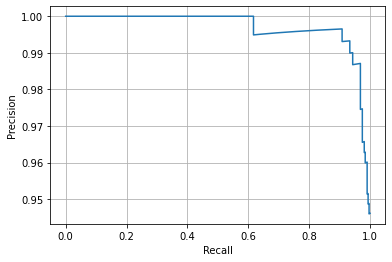

In [31]:
val_prob = predict(x=x_val, w=weights, return_prob=True)
precision, recall, thresholds = precision_recall_curve(y_val, val_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()

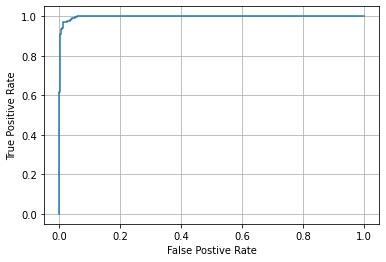

In [32]:
fpr, tpr, thresholds = roc_curve(y_val, val_prob)

plt.plot(fpr, tpr)
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.grid()

In [33]:
num_epochs = 500
batch_size = 1
weights = np.random.normal(loc=0, scale=np.sqrt(2/(x.shape[1])), size=x.shape[1]-1)
weights = np.append(weights, 0.)
alpha = 1e-1
min_val_cost = np.inf
patience = 0
max_weights = weights

val_cost_list["sgd"] = []
val_acc_list["sgd"] = []

train_cost_list["sgd"] = []
train_acc_list["sgd"] = []

wolfe_II_list["sgd"] = []
goldstein_list["sgd"] = []


for i in range(num_epochs):
    index = np.arange(x_train.shape[0])
    np.random.shuffle(index)
    for j in range(ceil(x_train.shape[0]/64)):
        index_batch = index[j * batch_size: j * batch_size + batch_size]
        x_batch = x_train[index_batch]
        y_batch = y_train[index_batch]
        #x_batch = x_train[j * batch_size: j * batch_size + batch_size]
        #y_batch = y_train[j * batch_size: j * batch_size + batch_size]
        #print(x_batch.shape, y_batch.shape)

        dweights = derivative_cost_wrt_params(x=x_batch, w=weights, y=y_batch)
        alpha = backtracking_line_search(x=x_batch, w=weights, y=y_batch, p=-dweights, rho=0.9, alpha=1e-1, c=0.0001)
        #alpha = line_search(x=x_batch, w=weights, y=y, p=-dweights, alpha_max=1e-1, c_1=0.0001, c_2=0.9)
        #print(alpha)

        wolfe_II_list["sgd"].append(check_wolfe_II(x=x_batch, w=weights, y=y_batch, alpha=alpha, p=-dweights, c_2=0.9))
        goldstein_list["sgd"].append(check_goldstein(x=x_batch, w=weights, y=y_batch, alpha=alpha, p=-dweights, c=0.25))
        weights -= alpha * dweights

        cost = sigmoid_cross_entropy_with_x_w(x=x_batch, w=weights, y=y_batch)
        
        tr_output = predict(x=x_batch, w=weights, threshold=0.6).astype(np.float)
        tr_acc = (tr_output == y_batch).sum()/y_batch.shape[0]
        #print(i, j, cost, tr_acc)

    cost = sigmoid_cross_entropy_with_x_w(x=x_train, w=weights, y=y_train)
    tr_output = predict(x=x_train, w=weights, threshold=0.6).astype(np.float)
    tr_acc = (tr_output == y_train).sum()/y_train.shape[0]
    val_cost = sigmoid_cross_entropy_with_x_w(x=x_val, w=weights, y=y_val)
    val_output = predict(x=x_val, w=weights, threshold=0.6).astype(np.float)
    val_acc = (val_output == y_val).sum()/y_val.shape[0]

    val_cost_list["sgd"].append(val_cost)
    val_acc_list["sgd"].append(val_acc)

    train_cost_list["sgd"].append(cost)
    train_acc_list["sgd"].append(tr_acc)


    print(i, cost, tr_acc, val_cost, val_acc)
    #if val_cost < min_val_cost:
    #    min_val_cost = val_cost
    #    patience = 0
    #    max_weights = weights
    #else:
    #    patience += 1
#
    ##if patience >= 20 and np.allclose(dweights, np.zeros_like(dweights), rtol=1e-3, atol=1e-5):
    #if patience >= 100:
    #    weights = max_weights
    #    print("Stop at epoch {}, restore weights".format(i))
    #    break

0 0.7593007294017711 0.49980276134122287 0.783650182665225 0.5007898894154819
1 0.5845756084574394 0.526232741617357 0.6312541123477432 0.4960505529225908
2 0.5916789287771497 0.5230769230769231 0.64081072083844 0.5165876777251185
3 0.5120995055794063 0.6777120315581854 0.5769456436068381 0.6161137440758294
4 0.5049711559471027 0.6378698224852071 0.5697064301354636 0.5608214849921012
5 0.4980898395310042 0.8560157790927022 0.5733576427182578 0.7993680884676145
6 0.4630847788725951 0.7238658777120316 0.5310925631119044 0.669826224328594
7 0.4530923475447646 0.7080867850098619 0.5193700014868649 0.641390205371248
8 0.43851315215317455 0.7364891518737673 0.500906590252348 0.6777251184834123
9 0.43991332670187433 0.8942800788954635 0.499650156781817 0.8672985781990521
10 0.44730316502935835 0.672189349112426 0.5150932900776936 0.5781990521327014
11 0.42653831506669626 0.8986193293885602 0.4910076664012284 0.8593996840442338
12 0.4006312877261622 0.7502958579881657 0.46211315071444875 0.703

In [34]:
weights, dweights

(array([  0.97718227,   1.72253333,  -0.24161277,  -2.47259202,
          3.86753693,   5.80538491,  -0.82838041,  -0.84478389,
          4.43037031,  -2.89064705,   0.57666764,   0.98893374,
        -18.92783598,   1.70761019,  -0.71121629,   0.26943764,
          0.12087757,   0.19840673,   0.12353159,  -0.3396877 ,
          2.20532432]),
 array([-2.06981784e-02, -1.30845174e-02, -2.31074993e-02, -1.49224288e-02,
        -2.57912324e-02, -1.29587729e-02, -1.36714854e-03, -8.55030562e-05,
        -1.89763833e-02, -1.16322219e-02, -2.60977472e-02, -2.06981784e-02,
        -1.14040802e-02, -5.60809048e-03, -2.83901178e-02, -1.44532979e-02,
        -1.19274292e-03, -8.00191349e-03, -7.98675691e-03, -4.86673040e-03,
        -2.91908135e-02]))

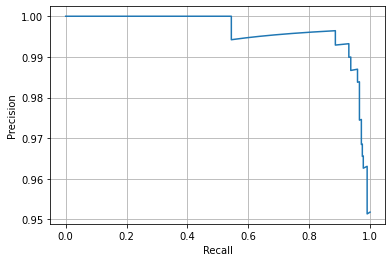

In [35]:
val_prob = predict(x=x_val, w=weights, return_prob=True)
precision, recall, thresholds = precision_recall_curve(y_val, val_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()

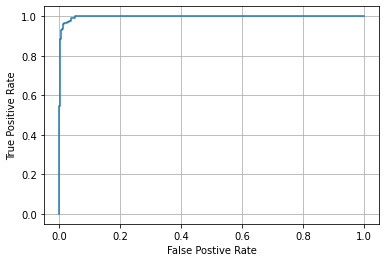

In [36]:
fpr, tpr, thresholds = roc_curve(y_val, val_prob)

plt.plot(fpr, tpr)
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.grid()

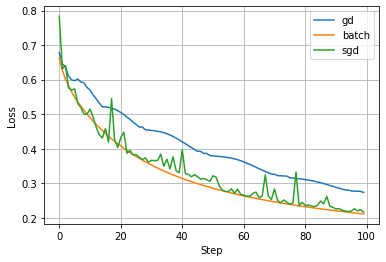

In [37]:
for method in val_cost_list:
    #plt.plot(np.arange(len(val_cost_list[method])), val_cost_list[method], label=method)
    plt.plot(np.arange(100), val_cost_list[method][:100], label=method)

plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid()
plt.legend()

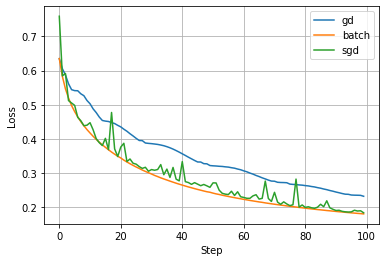

In [38]:
for method in train_cost_list:
    #plt.plot(np.arange(len(val_cost_list[method])), val_cost_list[method], label=method)
    plt.plot(np.arange(100), train_cost_list[method][:100], label=method)

plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid()
plt.legend()

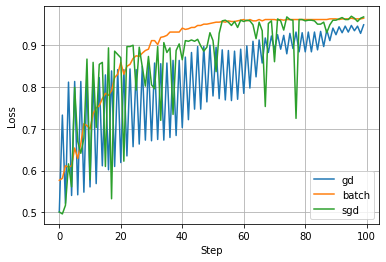

In [39]:
for method in val_acc_list:
    #plt.plot(np.arange(len(val_cost_list[method])), val_cost_list[method], label=method)
    plt.plot(np.arange(100), val_acc_list[method][:100], label=method)

plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid()
plt.legend()

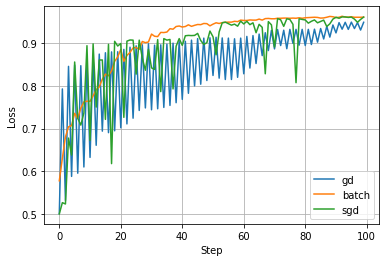

In [40]:
for method in train_acc_list:
    #plt.plot(np.arange(len(val_cost_list[method])), val_cost_list[method], label=method)
    plt.plot(np.arange(100), train_acc_list[method][:100], label=method)

plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid()
plt.legend()

In [41]:
wolfe_II_list

{'gd': [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  

In [42]:
goldstein_list

{'gd': [False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  Fa